In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate, signal

from tqdm.notebook import tqdm, trange
from tqdm.keras import TqdmCallback

import pathlib, sys, os
from os import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('classic')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# Reading subjects age data

In [3]:
subjects = pd.read_excel('ages.xlsx')[['Subject #','Age']]
train, test = train_test_split(subjects, test_size = 0.4, random_state = 7)
validation, test = train_test_split(test, test_size = 0.4, random_state = 7)


train = ['data//'+str(c) for c in train['Subject #'].values]
test = ['data//'+str(c) for c in test['Subject #'].values]
validation = ['data//'+str(c) for c in validation['Subject #'].values]


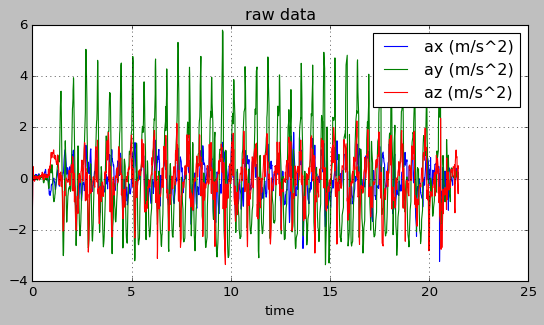

In [40]:
# example for raw data.
d = pd.read_csv(train[0]+'//d.csv').set_index('time')
d.iloc[:,:3].plot()
plt.title('raw data');

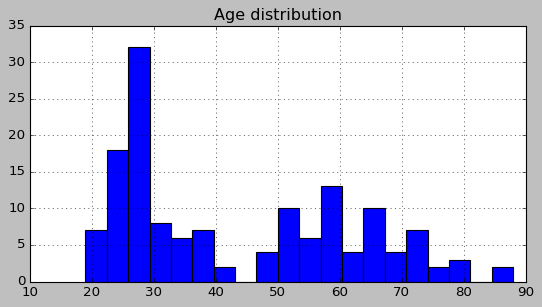

In [9]:
subjects['Age'].hist(bins = 20)
plt.title('Age distribution');

In [10]:
def fetch(subjects, freq = 100, n_seconds = 3, train = False):
    """
    A function to read subjects accelerometer data.
    
    params: 
        subjects : a list of subjects folders
        freq     : the sampling frequency all signals will be converted to
        n_seconds: number of seconds to fetch from each signal
        train    : if true, fetches two n_seconds signals from each recording, as data augmentation. default: False
    
    """
    
    output = pd.DataFrame() # output dataframe
        
    # for each subject, try to read accelerometer data
    for s in tqdm(subjects):
        try:
            data = pd.read_csv(s+'//d.csv')
            data.columns = ['time','x','y','z','t']
        except:
            print(s,':\t',sys.exc_info()[0])
            continue


        # remove very short recordings
        if data['time'].max() < 12:
            print(f'Too short dataset {s}: {data["time"].max()}')
            continue

        # data cleaning: if accelerometer is turned off, remove following data.
        off_phase = np.where(np.diff(data.time) > 1)[0]
        if off_phase.shape[0] > 0:
            data = data.loc[:off_phase[0]]

#         # calculate sampling frequency for each subject
        fs = data.time.idxmax() / data.time.max()
    
#         filtering the data with butterworth filter. this didn't improve the results, so we skip it
#         sos = signal.butter(1, 10, 'low', output = 'sos', fs = fs) 
    
        data.set_index('time', inplace = True)

        # take n_seconds measurements. we take n_seconds around the first quarter, as the middle point is 
        # often when the person turned back.
        if train:
            n_seconds *= 2
        middle = data.index.max() / 4
        start = middle - n_seconds / 2
        end = middle + n_seconds / 2
        data = data[(data.index > start) & (data.index < end)]

        # up/down sample to <freq> hz
        x = data.index
        xnew = np.linspace(min(x), max(x), freq * n_seconds)

        for c in data.columns[:-1]:
            y = data[c]          
#             y = signal.sosfilt(sos, y) # apply the butterworth filter
            f = interpolate.interp1d(x, y)
            ynew = f(xnew)
            temp = pd.DataFrame(ynew.reshape(1,-1))
            temp['Subject'] = int(s.split('//')[1])
            temp['Axis'] = c
            temp = temp[['Subject','Axis'] + list(range(freq * n_seconds))]
            output = output.append(temp, ignore_index = True)

    # attach demographics to accelerometer re-calculated data
    age = pd.read_excel('ages.xlsx') #.iloc[:,:-1]
    age.columns = ['Subject', 'Age', 'Gender']
    output = output.merge(age, how = 'left', on = 'Subject')
    output = output[['Subject','Age','Gender','Axis'] + list(range(freq * n_seconds))]
    return output

# call the fetch function to read data
split_train = False
newfreq = 128
n_seconds = 4

train_output = fetch(train, freq = newfreq, n_seconds = n_seconds, train = split_train)
test_output = fetch(test, freq = newfreq, n_seconds = n_seconds)
validation_output = fetch(validation, freq = newfreq, n_seconds = n_seconds)


# in case we used split_train (doubling train data) we have to split it. We don't use it currently.
if split_train:
    train_output_b = pd.concat([train_output[['Subject','Age','Gender','Axis']], train_output[np.arange(500,1000)]], axis = 1)
    train_output_b.columns = ['Subject','Age','Gender','Axis'] + [c for c in range(500)]
    train_output = train_output.iloc[:,:504]
    train_output = pd.concat([train_output_b, train_output])
    train_output.reset_index(inplace = True, drop = True)
    

  0%|          | 0/87 [00:00<?, ?it/s]

Too short dataset data//86: 8.819899
data//57 :	 <class 'FileNotFoundError'>
data//93 :	 <class 'FileNotFoundError'>
Too short dataset data//21: 10.707
Too short dataset data//85: 9.720683
data//62 :	 <class 'FileNotFoundError'>
Too short dataset data//82: 9.07261
data//75 :	 <class 'FileNotFoundError'>
data//79 :	 <class 'FileNotFoundError'>


  0%|          | 0/24 [00:00<?, ?it/s]

Too short dataset data//88: 9.484914
data//48 :	 <class 'FileNotFoundError'>
data//58 :	 <class 'FileNotFoundError'>
Too short dataset data//87: 10.611134


  0%|          | 0/34 [00:00<?, ?it/s]

Too short dataset data//83: 10.657971
Too short dataset data//84: 8.884408
Too short dataset data//102: 11.751869916915894


,Subject,Age,Gender,Axis,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,91,26,M,x,-0.8833,-1.388624,-1.439136,-1.358980,-1.244788,-1.204488,...,0.015052,0.232912,0.476305,0.739156,1.001450,1.176949,1.144548,1.000439,0.796523,0.2750
1,91,26,M,y,-0.5760,-1.734108,-2.024860,-2.051898,-1.910358,-1.676000,...,2.231224,2.455478,2.836277,3.433456,4.120756,4.804587,5.179559,5.250668,5.128114,4.2861
2,91,26,M,z,-1.6047,-1.674845,-1.393175,-1.004953,-0.594393,-0.348633,...,2.102546,1.665326,1.042360,0.806536,1.265563,0.889356,0.349729,-0.059547,-0.350031,-0.8453
3,112,28,F,x,-0.5700,-0.523628,-0.534484,-0.569158,-0.603832,-0.629270,...,1.060666,1.045111,1.014775,0.752975,0.700970,0.632594,0.349415,-0.070249,-0.738520,-0.9900


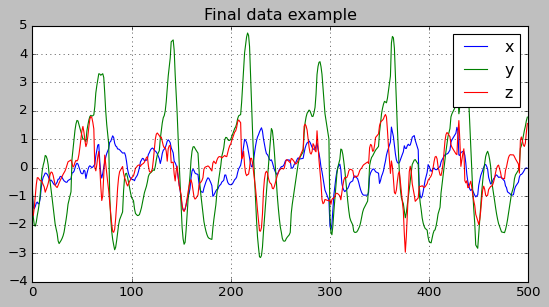

In [25]:
# we get three lines per subject - representing the accelerometer's x, y and z components.
display(train_output.head(4))

# and we can see an example
train_output.loc[:2,np.arange(500)].T.plot()
plt.legend(labels = ['x','y','z'])
plt.title('Final data example');

In [29]:
# we generate numpy arrays (train, validation and test) for both X and y
n = int(n_seconds * newfreq)
y_train = train_output.loc[np.arange(0, len(train_output), 3), 'Age'].values
X_train = train_output[np.arange(n)].values.reshape(-1, 3, n)
X_train = np.transpose(X_train, [0,2,1])

y_validation = validation_output.loc[np.arange(0, len(validation_output), 3), 'Age'].values
X_validation = validation_output[np.arange(n)].values.reshape(-1, 3, n)
X_validation = np.transpose(X_validation, [0,2,1])

y_test = test_output.loc[np.arange(0, len(test_output), 3), 'Age'].values
X_test = test_output[np.arange(n)].values.reshape(-1, 3, n)
X_test = np.transpose(X_test, [0,2,1])

In [27]:
# scaling is optional. however, we did not find it to be useful with this data, so we will not scale the data.

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = StandardScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    
# for i in range(X_validation.shape[1]):
#     X_validation[:, i, :] = scalers[i].transform(X_validation[:, i, :]) 

In [30]:
# save the pre-processed data to files
try:
    makedirs('scaled_dataset')
except:
    print('folder already exists')

np.save('scaled_dataset//X_train.npy', X_train)
np.save('scaled_dataset//y_train.npy', y_train)

np.save('scaled_dataset//X_validation.npy', X_validation)
np.save('scaled_dataset//y_validation.npy', y_validation)

np.save('scaled_dataset//X_test.npy', X_test)
np.save('scaled_dataset//y_test.npy', y_test)

folder already exists


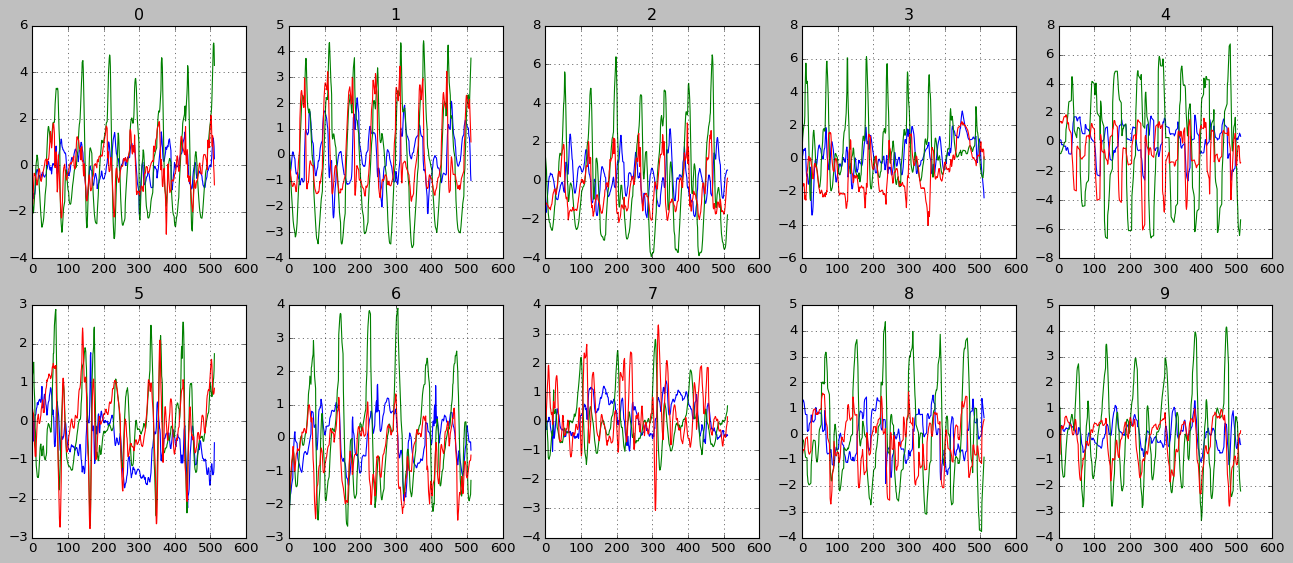

In [41]:
# plot some more examples
fig, axes = plt.subplots(figsize = (20,8), nrows = 2, ncols = 5)
for i in range(10):
    ax = axes.flatten()[i]
    ax.plot(X_train[i])
    ax.set_title(str(i))

# building the model

In [43]:

def plot_results(y_true, y_pred, history = None, class_th = 0.5):
    """
    a function to plot model performance
    
    y_true  : ground truth labels
    y_pred  : predictions made by the model
    history : training and validation loss and accuracy (optional)
    class_th: threshold for classification    
    """
    
    # calculate prediction classes
    y_pred_class = y_pred > class_th
    
    # calculate precision and recall curve
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)

    # print classification report
    print(classification_report(y_true, y_pred_class))

    if history:
        fig, axes = plt.subplots(figsize = (12,7), ncols = 2, nrows = 2)
    else:
        fig, axes = plt.subplots(figsize = (12,4), ncols = 2)

    # plot confusion matrix
    ax = axes.flatten()[0]
    sns.heatmap(confusion_matrix(y_true, y_pred_class), annot = True, ax = ax,cmap='Blues', fmt='g')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Predicted')

    # plot individual cases: true labels vs. given probability
    ax = axes.flatten()[1]
    y_jitter = y_true + np.random.normal(loc = 0, scale = 0.025, size = y_true.shape)
    ax.scatter(y_jitter, y_pred)
    ax.hlines(class_th, -0.25,1.25, color = 'green', ls = '--')
    ax.set_ylabel('p(X=OLD)')
    ax.set_xlabel('Age')

    # plot train and validation loss and accuracy
    if history:
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        ax = axes.flatten()[2]
        ax.plot(epochs, accuracy, color = 'red', marker = 'o', alpha = 0.7, label="Training accuracy")
        ax.plot(epochs, val_accuracy, color = 'green', marker = 'o', label="Validation accuracy", alpha = 0.8)
        
        w = int((len(val_accuracy) // 2.5) // 2 * 2 + 1) # savgol_gulary filter window size
        smooth_val_accuracy = signal.savgol_filter(val_accuracy, w, 3)
        ax.plot(epochs, smooth_val_accuracy, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_accuracy, color = 'green', ls = '--', lw = '2')

        
        ax.set_title("Accuracy")

        ax = axes.flatten()[3]
        ax.plot(epochs, loss, color = 'red', alpha = 0.7, marker = 'o', label="Training")
        ax.plot(epochs, val_loss, color = 'green', marker = 'o', label="Validation", alpha = 0.8)
        
        smooth_val_loss = signal.savgol_filter(val_loss, w, 3)
        ax.plot(epochs, smooth_val_loss, color = 'black', lw = '2')
        ax.plot(epochs, smooth_val_loss, color = 'green', ls = '--', lw = '2')
        
        ax.set_title("Loss")
        ax.legend(loc = 'best')

    plt.tight_layout()
    plt.show()


## preparing data sets

In [46]:

batch_size = 32
ageThreshold = 45

# fileFolder = pathlib.Path('drive//MyDrive//DeepLearningProject//gait_dataset')
fileFolder = pathlib.Path(os.getcwd() + '\\scaled_dataset')

X_train = np.load(fileFolder / 'X_train.npy')
y_train = np.load(fileFolder / 'y_train.npy')
fileShape = X_train.shape[1]

X_validation = np.load(fileFolder / 'X_validation.npy')
y_validation = np.load(fileFolder / 'y_validation.npy')

X_test = np.load(fileFolder / 'X_test.npy')
y_test = np.load(fileFolder / 'y_test.npy')


# defining classes as categorical
y_train = (y_train > ageThreshold).astype(int).reshape(-1,1)
y_validation = (y_validation > ageThreshold).astype(int).reshape(-1,1)
y_test = (y_test > ageThreshold).astype(int).reshape(-1,1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = batch_size, reshuffle_each_iteration=True).batch(batch_size = batch_size)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size = batch_size)

print(f"Train shape: {X_train.shape}, Validation shape: {X_validation.shape}, Test shape: {X_test.shape}")

for j in ['train','validation','test']:
    x = np.unique(eval(f"y_{j}"), return_counts = True)[1]
    print(f"% True label in {j}: {x[1] / x.sum() * 100:.1f}%")
        
        

Train shape: (78, 512, 3), Validation shape: (31, 512, 3), Test shape: (20, 512, 3)
% True label in train: 41.0%
% True label in validation: 45.2%
% True label in test: 30.0%


# building the model

In [47]:
seed = 21
np.random.seed(seed)
tf.random.set_seed(seed)

inputs = keras.Input(shape = (fileShape, 3))

x = inputs
# instead of augmentation, we used dropout on the inputs, to force the model to learn from all possible factors
x = layers.Dropout(0.8)(x) 

# since we have a very small dataset, we used a simple convolution network.
x = layers.Conv1D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.Conv1D(filters = 3, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = layers.Conv1D(filters = 4, kernel_size = 3, activation = 'relu', padding = 'same', kernel_regularizer = 'l2')(x)

x = layers.Dropout(0.5)(x)
x = layers.MaxPool1D(pool_size = 2)(x)

x = layers.Flatten()(x)
x = layers.Dense(100, activation = "selu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

optimizer = keras.optimizers.Adam()

# since our data in now always precisely balanced, we are more intreasted in precision and recall than accuracy.
model.compile(loss="binary_crossentropy",
              optimizer = optimizer,
              metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()],
              )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 3)]          0         
                                                                 
 dropout (Dropout)           (None, 512, 3)            0         
                                                                 
 conv1d (Conv1D)             (None, 512, 2)            20        
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 3)            21        
                                                                 
 conv1d_2 (Conv1D)           (None, 512, 4)            40        
                                                                 
 dropout_1 (Dropout)         (None, 512, 4)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 4)           0     

## training the model

0epoch [00:00, ?epoch/s]

1/1 [==============================] - 1s 518ms/step - loss: 0.6823 - accuracy: 0.7097 - precision_324: 0.6923 - recall_324: 0.6429
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.69      0.64      0.67        14

    accuracy                           0.71        31
   macro avg       0.71      0.70      0.70        31
weighted avg       0.71      0.71      0.71        31



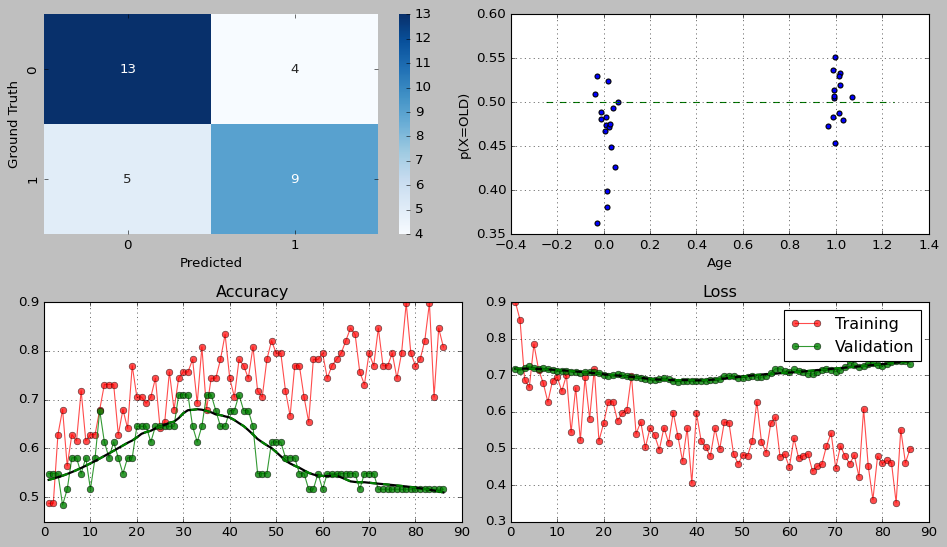

In [56]:
epochs = 250

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn.keras",
        save_best_only=True,
        monitor="val_loss"),
    
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     min_delta=0,
                                     patience=epochs // 5,
                                     restore_best_weights = False),
                                     
    TqdmCallback(verbose=0),]

history = model.fit(train_dataset,
                    epochs = epochs,
                    verbose = 0,
                    validation_data = validation_dataset,
                    callbacks = callbacks,
                    shuffle = True
                   )

model = keras.models.load_model("cnn.keras")
loss, acc, prec, rec = model.evaluate(validation_dataset)

y_pred = model.predict(validation_dataset).flatten()
plot_results(y_validation, y_pred, history)


## and finally - testing our model on the un-seen data

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       0.62      0.83      0.71         6

    accuracy                           0.80        20
   macro avg       0.77      0.81      0.78        20
weighted avg       0.83      0.80      0.81        20



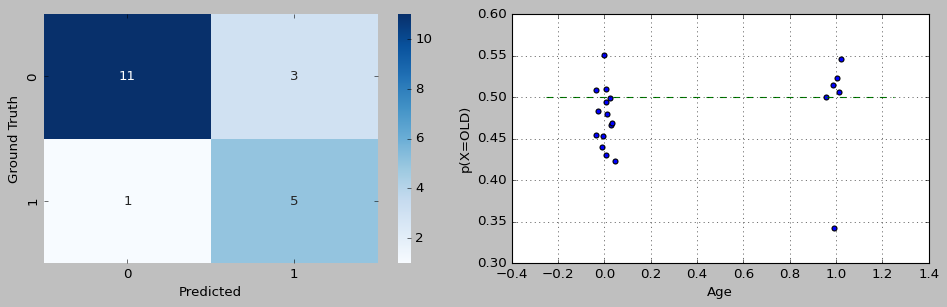

In [54]:
y_pred = model.predict(test_dataset).flatten()
plot_results(y_test, y_pred)



## Conclusions

based on this model, and on the small dataset, it seems that there is plausibility to continue with this project!
next stage will be to train to refine the model, and perhaps try to use a regression model, instead of a classifier.